In [255]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
#from SpykeTorch import makeInput
#import cifar10

import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [256]:
rf_size = 28 # Receptive field size that will be provided as input to the column
num_neurons = rf_size*rf_size # Number of excitatory neurons in the column
startposition = 0 # Start position of the receptive field w.r.t. top left corner of image
threshold = 75 # Firing threshold for every excitatory neuron
timesteps = 8 # Resolution for timesteps and weights

In [257]:
class PreProcTransform:
    def __init__(self, filter, timesteps = timesteps):
        self.to_tensor = transforms.ToTensor() # Convert to tensor
        self.filter = filter # Apply OnOff filtering
        self.temporal_transform = utils.Intensity2Latency(timesteps) # Convert pixel values to time
                                                    # Higher value corresponds to earlier spiketime
        self.crop = utils.Crop(startposition, rf_size) # Crop the image to form the receptive field
        
    def __call__(self, image):
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0) # Adds a temporal dimension at the beginning
        image = self.filter(image)
        temporal_image = self.temporal_transform(image)
        temporal_image = temporal_image.sign() # This will create spikes
        return self.crop(temporal_image)
    
kernels = [utils.OnKernel(3), utils.OffKernel(3)]
inchannels = len(kernels)

filter = utils.Filter(kernels, padding = 2, thresholds = 50)
preproc = PreProcTransform(filter)

In [258]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=10, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)

In [259]:
class Column(nn.Module):
    def __init__(self):
        super(Column, self).__init__()
        # Local Convolution layer which creates columns with unique weights (NOT shared weights). The
        # number of columns is based on input_size, kernel_size and stride. Here since we are simulating
        # only one column, the input_size and kernel_size are kept same.
        self.ec = snn.HopfieldNetwork(10/128, 10/128, 40/128, 56/128, 4/128, timesteps)
        # STDP module which implements the given STDP rule for the above layer (a single column in this case)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)
        
    def forward(self, rec_field):
        ### Start of Excitatory Column ###
        out = self.ec(rec_field)
        #spike, pot = sf.fire(out, threshold, True)
        ### End of Excitatory Column ###
        ### Start of Lateral Inhibition ###
        #out = sf.pointwise_inhibition(pot).sign()
        ### End of Lateral Inhibition ###
        return out

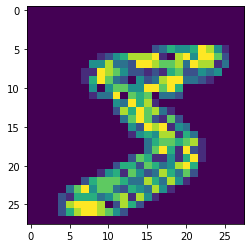

In [13]:
MyColumn=Column()
train_pattern=[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)]#,torch.sum(torch.sum(MNIST_train[2][0],dim=0),dim=0)]#[torch.tensor([7,0,0,0,0,7,0,0,0,0,7,0,0,0,0,7]).type(torch.FloatTensor).reshape(4,4)]
MyColumn.ec.train_weights(train_pattern)#[torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4)])#[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
plt.imshow(train_pattern[0])#torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4))#torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))
#MyColumn.ec.train_weights([torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
#plt.imshow(torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))

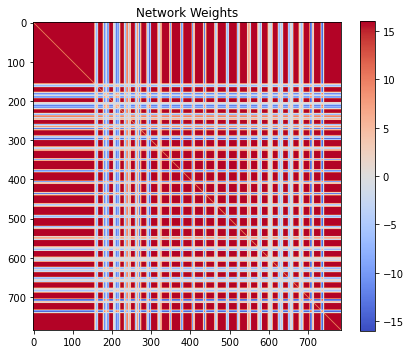

In [15]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(MyColumn.ec.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.show()

In [17]:
pattern=torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0).reshape(784)#torch.tensor([0]*784).type(torch.FloatTensor)#torch.tensor([2,6,3,1,7,4,5,2,7,7,7,7,3,7,5,5]).type(torch.FloatTensor)#(torch.tensor([0,1,2,3,4,5,6,7]*2).type(torch.FloatTensor))#torch.sum(torch.sum(MNIST_train[1][0],dim=0),dim=0).reshape(784)-4)/4
out=MyColumn.ec.forward([(pattern-4).clone()],20)

tensor([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -2., -1.,  1.,  0.,  0.,  1.,  4.,  3.,  0., -3., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -3., -2.,  

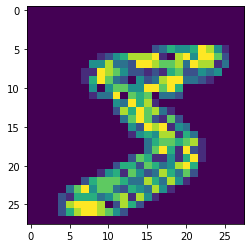

In [19]:
plt.imshow((pattern-4).reshape(28,28))

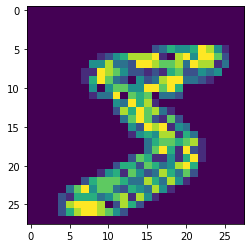

In [21]:
plt.imshow(torch.sum(out,dim=0))

In [23]:
out

tensor([[[-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
         [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
          -4., -4., -2., -1.,  1.,  0.,  0.,  1.,  4.,  3.,  0., -3., -4., -4.],
         [-4., -4., -4., -4., -4.,

In [25]:
pattern-4

tensor([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -2., -1.,  1.,  0.,  0.,  1.,  4.,  3.,  0., -3., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -3., -2.,  

In [27]:
distance.hamming(out.reshape(784),(train_pattern[0]-4).reshape(784))

0.0

In [29]:
distance.hamming(out.reshape(784),(pattern-4))

0.0

In [335]:
# 1
# make dataset and split into training and test
BATCH_SIZE = 10

def reshape_images(images):
    return torch.sum(images, dim=2).reshape(BATCH_SIZE, 8, 784)

def cluster_membership(image, cluster_centers):
    hamming_array = torch.zeros(BATCH_SIZE)
    #print(image)
    for i in range(BATCH_SIZE):
        hamming_array[i] = distance.hamming(image,cluster_centers[i])

    #print(hamming_array)

    return torch.argmin(hamming_array)

def expectation(batch, cluster_centers):
    cluster_counts = torch.zeros(BATCH_SIZE)
    cluster_image_sum = torch.zeros(cluster_centers.size())

    for i in range(BATCH_SIZE):
        #print(batch[i].shape)
        cluster_index = cluster_membership(torch.sum(batch[i],dim=0), torch.sum(cluster_centers,dim=1))
        #print("Cluster idx: ",cluster_index)
        cluster_image_sum[cluster_index] += batch[i]
        cluster_counts[cluster_index] += 1
    
    return cluster_counts, cluster_image_sum

def training_converged(old_cluster_centers, cluster_centers):
    return torch.all(torch.eq(old_cluster_centers,cluster_centers))

# N = 1000 samples from train
cluster_centers = None
ClusteringColumn = Column()
init = False
cluster_image_sum_total = None
cluster_counts_total = None
converged = False

iteration=0
#while (~converged):
for i in range(10):
    print("Iteration: ", iteration)

    for batch_ndx, (sample,label) in enumerate(MNIST_trainLoader):
        #print("Batch: ", batch_ndx)
        if (~init):
            cluster_centers = reshape_images(sample.clone())
            init = True
        # train with current cluster centers
        if batch_ndx == 0:
            cluster_image_sum_total = torch.zeros(cluster_centers.size())
            cluster_counts_total = torch.zeros(BATCH_SIZE)
            ClusteringColumn.ec.train_weights(cluster_centers)

        test=reshape_images(sample)
        out = ClusteringColumn.ec.forward(reshape_images(sample),threshold=100)
        cluster_counts, cluster_image_sum =  expectation(out, cluster_centers)
        cluster_counts_total += cluster_counts
        cluster_image_sum_total += cluster_image_sum
        #print(cluster_counts)

        if batch_ndx == 100:
            break

    old_cluster_centers = cluster_centers.clone()
    cluster_centers = cluster_image_sum_total/(cluster_counts_total.unsqueeze(1).repeat(1,8).unsqueeze(2).repeat(1,1,784))

    converged = training_converged(old_cluster_centers, cluster_centers)
    iteration += 1


# train with 10 random samples(these are also init cluster centers)
# pass each training image to network, determine hamming between output and cluster centers
# record counts for each clusters
# keep sums of patterns associated with each cluster
#   sum normalized by count and these are new cluster centers
# train new network with new cluster centers
# repeat until convergence
# 

Iteration:  0


KeyboardInterrupt: 

In [25]:
print(cluster_image_sum_total.shape)

torch.Size([10, 8, 784])


In [26]:
print(cluster_counts_total.unsqueeze(1).repeat(1,784).shape)

torch.Size([10, 784])


In [27]:
cluster_counts_total.unsqueeze(1).repeat(1,8).unsqueeze(2).repeat(1,1,784).shape

torch.Size([10, 8, 784])

In [336]:
cluster_centers.shape

torch.Size([10, 8, 784])

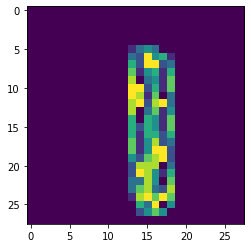

In [88]:
plt.imshow(torch.sum(test[5],dim=0).reshape(28,28))

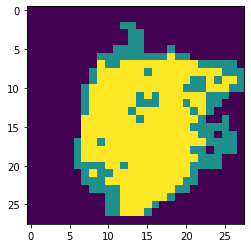

In [145]:
plt.imshow(torch.sum(out[9],dim=0).reshape(28,28))

In [135]:
torch.sum(cluster_centers[2],dim=0)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [81]:
test

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

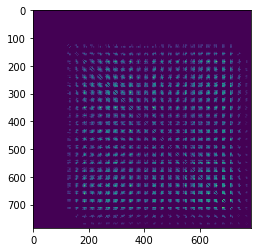

In [98]:
plt.imshow(ClusteringColumn.ec.W)

In [260]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.FashionMNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.FashionMNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=10, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)

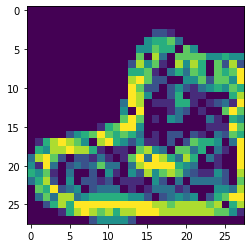

In [261]:
plt.imshow(torch.sum(torch.sum(MNIST_train.__getitem__(0)[0],dim=1),dim=0))

In [309]:
def make_noisy_sample(image,prob):
    for pixel in range(784):
        random_draw = torch.rand(1)
        if random_draw >= prob:
            image[pixel] = torch.randint(0,8,(1,1))
    transform=utils.Intensity2Latency(8)
    return transform(image).sign()

In [310]:
seeds=[]
for i in range(10):
    seeds.append(MNIST_train.__getitem__(i)[0].reshape(8,2,784))

In [311]:
dataset=[]
for image in seeds:
    for i in range(100):
        prob=torch.rand(1)
        dataset.append(make_noisy_sample(torch.sum(torch.sum(image,dim=0),dim=0),prob).reshape(8,28,28))

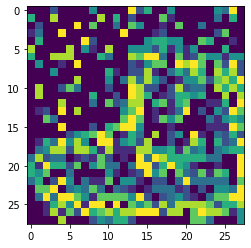

In [327]:
plt.imshow(torch.sum(dataset[13],dim=0))

In [328]:
MyColumn=Column()

In [329]:
MyColumn.ec.train_weights(seeds)

AttributeError: 'list' object has no attribute 'size'

In [334]:
torch.sum(torch.sum(seeds[0],dim=1).shape

torch.Size([784])